In [1]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from Data.dataloader import data_class, dataloader
from Methods.ConvNet import ConvNet
from Methods.EvidenceNet import EvidenceNet
from Methods.EvidenceNetwoKL import EvidenceNetwoKL
from Methods.ReconEvidenceNet import ReconEvidenceNet
from Methods.ROLENet import ROLENet
from Methods.REDL import R_EvidenceNet
from Methods.IEDL import I_EvidenceNet

from Methods.SubEvidenceNet import SubEvidenceNet

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

from Utils.evaluation import metric_ood

In [2]:
def draw_binary_hm(train_conf, valid_conf, ood_conf, percent, name):
    plt.figure(figsize=(6,6))
    threshold = np.percentile(train_conf, percent)
    TN = np.sum((ood_conf)<threshold)/len(ood_conf)
    TP = np.sum((valid_conf)>threshold)/len(valid_conf)
    # 绘制混淆矩阵，0为OOD，1为ID，横纵轴标记
    print()
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    sns.heatmap([[TN, 1-TN],[1-TP, TP]], annot=True, fmt='.2f', annot_kws={"size": 30}, cmap='Blues', cbar=False, xticklabels=['OOD','ID'], yticklabels=['OOD','ID'], vmin=0.2, vmax=0.85)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()
    plt.close()
    plt.rcdefaults()
    return TN, TP

In [3]:
@torch.no_grad()
def evaluate(model, data_loader, epoch, ood=False):
    model.eval()
    size = 0
    running_loss = 0.0
    running_corrects = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    epoch_output=[]
    epoch_features=[]
    epoch_targets=[]
    with tqdm(total=len(data_loader),ncols=90) as pbar:
        if ood:
            pbar.set_description('Evaluate OOD: %d' % epoch)
        else:
            pbar.set_description('Evaluate ID: %d' % epoch)
        for images, targets in data_loader:
            pbar.update(1)
            images = images.to(device)
            targets = targets.to(device).float()

            # Pass the inputs through the CNN model.
            features, outputs = model(images)
            epoch_output.append(outputs)
            epoch_features.append(features)
            epoch_targets.append(targets)

            loss = model.criterion(outputs, targets, 0, num_class, 10, device)

            _, preds = torch.max(outputs, 1)
            targets = torch.argmax(targets, dim=1)
            
            # Calculate the batch loss.
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == targets)
            size += images.size(0)

    # end epoch
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size 
    epoch_output = torch.cat(epoch_output, dim=0)
    epoch_features = torch.cat(epoch_features, dim=0)
    epoch_targets = torch.cat(epoch_targets, dim=0)
    # epoch_metrics = model.infer_metrics(epoch_features)

    return epoch_loss, epoch_acc, epoch_output, epoch_features, epoch_targets

def get_prob(output):
    alpha = torch.exp(output)+1
    alpha_0 = torch.sum(alpha, dim=1)
    prob = alpha/alpha_0.unsqueeze(1)
    return prob

def get_vacuity(output):
    alpha = torch.exp(output)+1
    alpha_0 = torch.sum(alpha, dim=1)
    vacuity = 1/(alpha_0)
    return vacuity.cpu().numpy()

def get_msp(prob):
    msp = torch.max(prob, dim=1).values
    return msp.cpu().numpy()

def get_entropy(prob):
    entropy = -torch.sum(prob*torch.log(prob), dim=1)
    return entropy.cpu().numpy()

def get_fpr95(id_metric,ood_metric):
    from sklearn.metrics import roc_curve
    positive_features = id_metric
    negative_features = ood_metric
    # 生成标签，正类为1，负类为0
    y_true = np.concatenate([np.ones(len(positive_features)), np.zeros(len(negative_features))])
    # 合并特征
    features = np.concatenate([positive_features, negative_features])
    # 计算FPR, TPR, 和阈值
    fpr, tpr, thresholds = roc_curve(y_true, features)
    # 找到TPR最接近95%的点
    target_tpr = 0.95
    closest_tpr_index = np.argmin(np.abs(tpr - target_tpr))
    fpr_at_target_tpr = fpr[closest_tpr_index]
    return fpr_at_target_tpr*100

dataset = 'isic'
num_class = data_class(dataset)
train_dl = dataloader(dataset=dataset, data_mode='train', batch_size=256, image_size=256)
valid_dl = dataloader(dataset=dataset, data_mode='valid', batch_size=256, image_size=256)
ood_dl = dataloader(dataset=dataset, data_mode='ood', batch_size=256, image_size=256)

18352
4587
492


## 1. ConvNet

In [4]:
convnet = ConvNet('ResNet18', num_class)
convnet.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/convnet_acc.pth')['model'])
convnet = convnet.cuda()

train_loss_conv, train_acc_conv, train_output_conv, train_features_conv, train_targets_conv = evaluate(convnet, train_dl, 1, ood=False)
valid_loss_conv, valid_acc_conv, valid_output_conv, valid_features_conv, valid_targets_conv = evaluate(convnet, valid_dl, 1, ood=False)
ood_loss_conv, ood_acc_conv, ood_output_conv, ood_features_conv, ood_targets_conv = evaluate(convnet, ood_dl, 1, ood=True)

train_prob_conv = torch.softmax(train_output_conv, dim=1)
valid_prob_conv = torch.softmax(valid_output_conv, dim=1)
ood_prob_conv = torch.softmax(ood_output_conv, dim=1)

train_msp_conv = get_msp(train_prob_conv)
valid_msp_conv = get_msp(valid_prob_conv)
ood_msp_conv = get_msp(ood_prob_conv)

print('acc:',valid_acc_conv.item(),'\n')
print('ConvNet-MSP')
ood_metric_msp_conv = metric_ood(valid_msp_conv, ood_msp_conv, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(valid_msp_conv, ood_msp_conv),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.76s/it]

acc: 0.8659254414650097 

ConvNet-MSP
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    15.244 70.318 66.347 95.252 19.098
fpr95: 84.5528455284553 



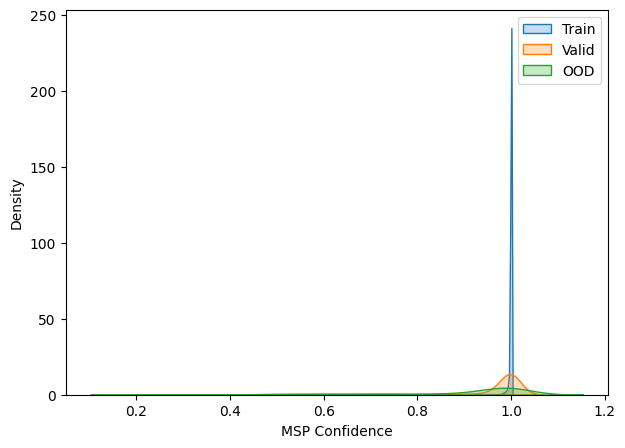

In [5]:
plt.figure(figsize=(7,5))
sns.kdeplot(train_msp_conv, label='Train', fill=True)
sns.kdeplot(valid_msp_conv, label='Valid', fill=True)
sns.kdeplot(ood_msp_conv, label='OOD', fill=True)
plt.xlabel('MSP Confidence')
plt.ylabel('Density')
plt.legend()
plt.savefig('density_msp.png')
plt.show()
plt.close()

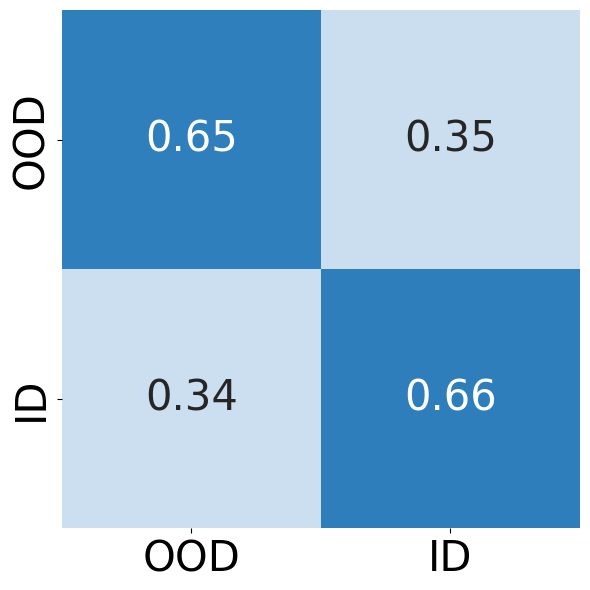

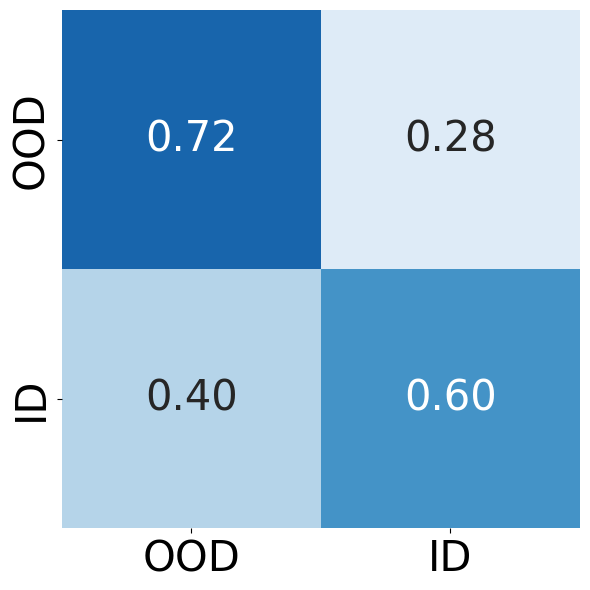

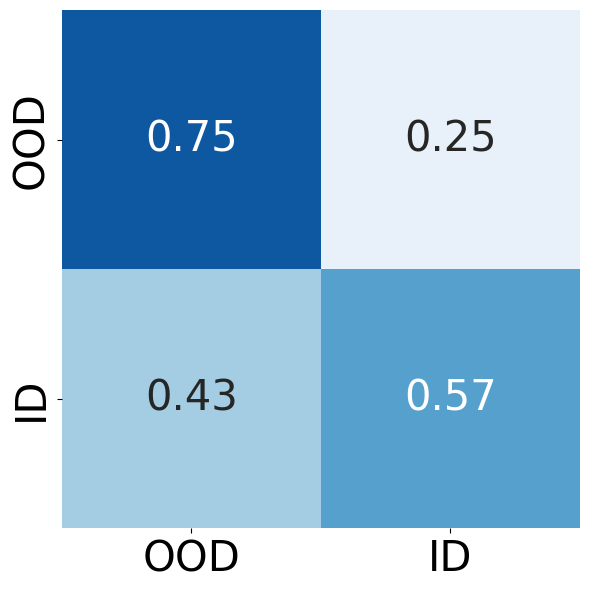

In [6]:
TNTP5_msp = draw_binary_hm(train_msp_conv, valid_msp_conv, ood_msp_conv, 5, 'thresh5_msp.png')
TNTP10_msp = draw_binary_hm(train_msp_conv, valid_msp_conv, ood_msp_conv, 10, 'thresh10_msp.png')
TNTP15_msp = draw_binary_hm(train_msp_conv, valid_msp_conv, ood_msp_conv, 15, 'thresh15_msp.png')

## 2. EvidenceNet

In [7]:
evidencenet = EvidenceNet('ResNet18', num_class, reg_kl=1)
evidencenet.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/evidencenet_acc.pth').state_dict())
evidencenet = evidencenet.cuda()

train_loss_evidence, train_acc_evidence, train_output_evidence, train_features_evidence, train_targets_evidence = evaluate(evidencenet, train_dl, 1, ood=False)
valid_loss_evidence, valid_acc_evidence, valid_output_evidence, valid_features_evidence, valid_targets_evidence = evaluate(evidencenet, valid_dl, 1, ood=False)
ood_loss_evidence, ood_acc_evidence, ood_output_evidence, ood_features_evidence, ood_targets_evidence = evaluate(evidencenet, ood_dl, 1, ood=True)

train_prob_evidence = get_prob(train_output_evidence)
valid_prob_evidence = get_prob(valid_output_evidence)
ood_prob_evidence = get_prob(ood_output_evidence)

train_vacuity_evidence = get_vacuity(train_output_evidence)
valid_vacuity_evidence = get_vacuity(valid_output_evidence)
ood_vacuity_evidence = get_vacuity(ood_output_evidence)

print('acc:',valid_acc_evidence.item(),'\n')
print('EvidenceNet-Vacuity')
ood_metric_vacuity_evidence = metric_ood(ood_vacuity_evidence, valid_vacuity_evidence, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_evidence, valid_vacuity_evidence),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.80s/it]

acc: 0.8681055155875299 

EvidenceNet-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    24.264 71.892 67.415 18.077 95.667
fpr95: 74.66753869631567 



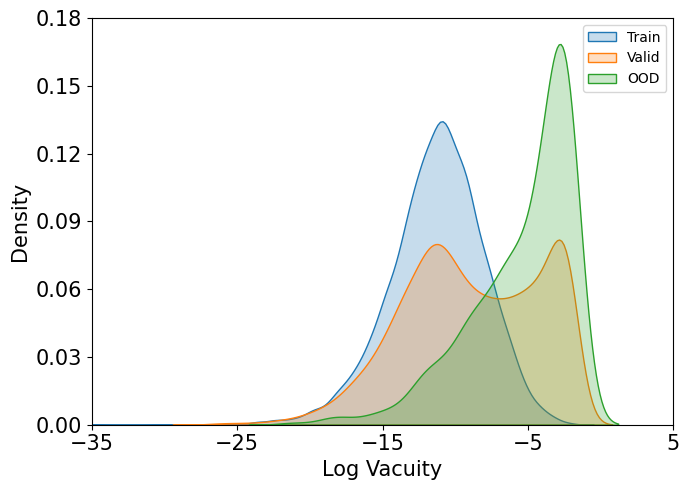

In [9]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_evidence), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_evidence), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_evidence), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(-35,5)
plt.ylim(0,0.18)
plt.xticks(np.arange(-35,6,10))
plt.yticks(np.arange(0,0.19,0.03))
plt.legend()
plt.tight_layout()
plt.savefig('density_evidence.png')
plt.rcdefaults()

## 2.a EvidenceNet without KL

In [10]:
evidencenetwokl = EvidenceNetwoKL('ResNet18', num_class)
evidencenetwokl.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/evidencenetwokl_acc.pth').state_dict())
evidencenetwokl = evidencenetwokl.cuda()

train_loss_eviwokl, train_acc_eviwokl, train_output_eviwokl, train_features_eviwokl, train_targets_eviwokl = evaluate(evidencenetwokl, train_dl, 1, ood=False)
valid_loss_eviwokl, valid_acc_eviwokl, valid_output_eviwokl, valid_features_eviwokl, valid_targets_eviwokl = evaluate(evidencenetwokl, valid_dl, 1, ood=False)
ood_loss_eviwokl, ood_acc_eviwokl, ood_output_eviwokl, ood_features_eviwokl, ood_targets_eviwokl = evaluate(evidencenetwokl, ood_dl, 1, ood=True)

train_prob_eviwokl = get_prob(train_output_eviwokl)
valid_prob_eviwokl = get_prob(valid_output_eviwokl)
ood_prob_eviwokl = get_prob(ood_output_eviwokl)

train_vacuity_eviwokl = get_vacuity(train_output_eviwokl)
valid_vacuity_eviwokl = get_vacuity(valid_output_eviwokl)
ood_vacuity_eviwokl = get_vacuity(ood_output_eviwokl)

print('acc:',valid_acc_eviwokl.item(),'\n')
print('EvidenceNetwoKL-Vacuity')
ood_metric_vacuity_eviwokl = metric_ood(ood_vacuity_eviwokl, valid_vacuity_eviwokl, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_eviwokl, valid_vacuity_eviwokl),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]

acc: 0.8781338565511226 

EvidenceNetwoKL-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    25.725 73.962 68.388 23.857 95.946
fpr95: 72.50926531502071 



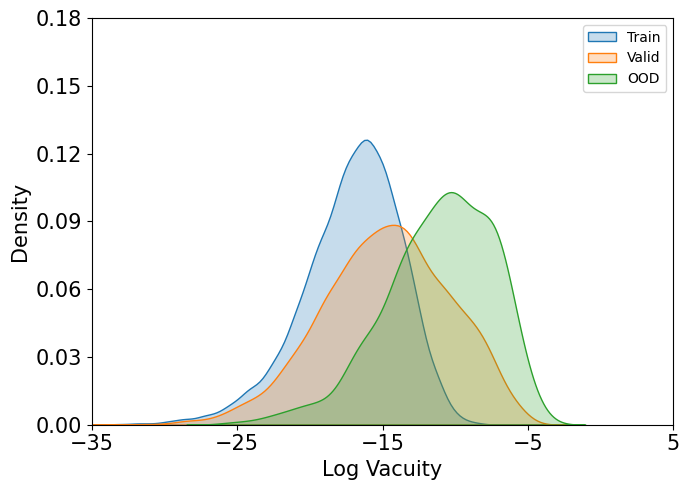

In [12]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_eviwokl), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_eviwokl), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_eviwokl), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(-35,5)
plt.ylim(0,0.18)
plt.xticks(np.arange(-35,6,10))
plt.yticks(np.arange(0,0.19,0.03))
plt.legend()
plt.tight_layout()
plt.savefig('density_eviwokl.png')

# 3. I-EDL

In [13]:
iedl = I_EvidenceNet('ResNet18', num_class)
iedl.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/iedl_acc.pth').state_dict())
iedl = iedl.cuda()

train_loss_iedl, train_acc_iedl, train_output_iedl, train_features_iedl, train_targets_iedl = evaluate(iedl, train_dl, 1, ood=False)
valid_loss_iedl, valid_acc_iedl, valid_output_iedl, valid_features_iedl, valid_targets_iedl = evaluate(iedl, valid_dl, 1, ood=False)
ood_loss_iedl, ood_acc_iedl, ood_output_iedl, ood_features_iedl, ood_targets_iedl = evaluate(iedl, ood_dl, 1, ood=True)

train_prob_iedl = get_prob(train_output_iedl)
valid_prob_iedl = get_prob(valid_output_iedl)
ood_prob_iedl = get_prob(ood_output_iedl)

train_vacuity_iedl = get_vacuity(train_output_iedl)
valid_vacuity_iedl = get_vacuity(valid_output_iedl)
ood_vacuity_iedl = get_vacuity(ood_output_iedl)

print('acc:',valid_acc_iedl.item(),'\n')
print('IEDL-Vacuity')
ood_metric_vacuity_iedl = metric_ood(ood_vacuity_iedl, valid_vacuity_iedl, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_iedl, valid_vacuity_iedl),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]

acc: 0.828864181382167 

IEDL-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas     6.366 62.478 62.776 14.148 92.813
fpr95: 93.61238282101591 



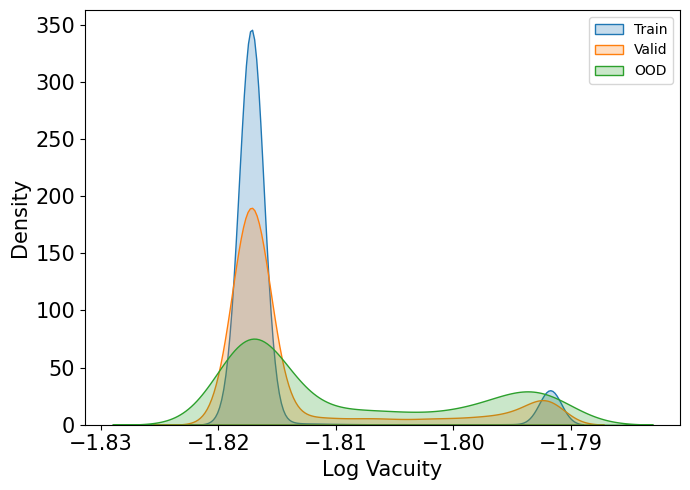

In [15]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_iedl), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_iedl), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_iedl), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('density_iedl.png')

# 4. R-EDL

In [16]:
redl = R_EvidenceNet('ResNet18', num_class)
redl.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/redl_acc.pth').state_dict())
redl = redl.cuda()

train_loss_redl, train_acc_redl, train_output_redl, train_features_redl, train_targets_redl = evaluate(redl, train_dl, 1, ood=False)
valid_loss_redl, valid_acc_redl, valid_output_redl, valid_features_redl, valid_targets_redl = evaluate(redl, valid_dl, 1, ood=False)
ood_loss_redl, ood_acc_redl, ood_output_redl, ood_features_redl, ood_targets_redl = evaluate(redl, ood_dl, 1, ood=True)

train_prob_redl = get_prob(train_output_redl)
valid_prob_redl = get_prob(valid_output_redl)
ood_prob_redl = get_prob(ood_output_redl)

train_vacuity_redl = get_vacuity(train_output_redl)
valid_vacuity_redl = get_vacuity(valid_output_redl)
ood_vacuity_redl = get_vacuity(ood_output_redl)

print('acc:',valid_acc_redl.item(),'\n')
print('IEDL-Vacuity')
ood_metric_vacuity_redl = metric_ood(ood_vacuity_redl, valid_vacuity_redl, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_redl, valid_vacuity_redl),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.96s/it]

acc: 0.8759537824286026 

IEDL-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas     7.369 65.254 64.398 16.517 93.412
fpr95: 92.39154131240463 



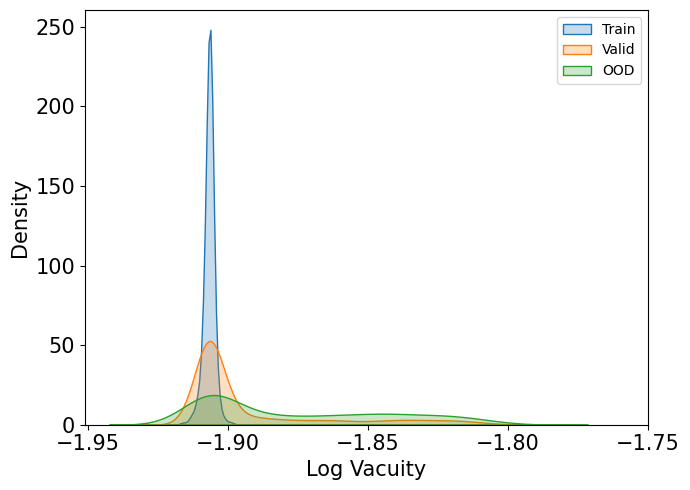

In [18]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_redl), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_redl), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_redl), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xticks(np.arange(-1.95,-1.74,0.05))
plt.legend()
plt.tight_layout()
plt.savefig('density_redl.png')

## 3. ReconevidenceNet

In [19]:
reconevidencenet = ReconEvidenceNet('ResNet18', num_class)
reconevidencenet.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/reconevidencenet_acc.pth').state_dict())
reconevidencenet = reconevidencenet.cuda()

train_loss_recon, train_acc_recon, train_output_recon, train_features_recon, train_targets_recon = evaluate(reconevidencenet, train_dl, 1, ood=False)
valid_loss_recon, valid_acc_recon, valid_output_recon, valid_features_recon, valid_targets_recon = evaluate(reconevidencenet, valid_dl, 1, ood=False)
ood_loss_recon, ood_acc_recon, ood_output_recon, ood_features_recon, ood_targets_recon = evaluate(reconevidencenet, ood_dl, 1, ood=True)

train_output_recont = train_output_recon
valid_output_recont = valid_output_recon
ood_output_recont = ood_output_recon

train_prob_recont = get_prob(train_output_recont)
valid_prob_recont = get_prob(valid_output_recont)
ood_prob_recont = get_prob(ood_output_recont)

train_vacuity_recont = get_vacuity(train_output_recont)
valid_vacuity_recont = get_vacuity(valid_output_recont)
ood_vacuity_recont = get_vacuity(ood_output_recont)

print('acc:',valid_acc_recon.item(),'\n')

print('ReconEvidenceNet-T-Vacuity')
ood_metric_vacuity_recont = metric_ood(ood_vacuity_recont, valid_vacuity_recont, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_recont, valid_vacuity_recont),'\n')


train_output_recon = torch.log(torch.exp(train_output_recon)-torch.min(torch.exp(train_output_recon),dim=1,keepdim=True)[0])
valid_output_recon = torch.log(torch.exp(valid_output_recon)-torch.min(torch.exp(valid_output_recon),dim=1,keepdim=True)[0])
ood_output_recon = torch.log(torch.exp(ood_output_recon)-torch.min(torch.exp(ood_output_recon),dim=1,keepdim=True)[0])

train_prob_recon = get_prob(train_output_recon)
valid_prob_recon = get_prob(valid_output_recon)
ood_prob_recon = get_prob(ood_output_recon)

train_vacuity_recon = get_vacuity(train_output_recon)
valid_vacuity_recon = get_vacuity(valid_output_recon)
ood_vacuity_recon = get_vacuity(ood_output_recon)

print('acc:', valid_acc_recon.item(),'\n')
print('ReconEvidenceNet-Vacuity')
ood_metric_vacuity_recon = metric_ood(ood_vacuity_recon, valid_vacuity_recon, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_recon, valid_vacuity_recon),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]

acc: 0.8779158491388707 

ReconEvidenceNet-T-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    21.953 74.397 68.352 23.778 95.895
fpr95: 77.54523653804229 

acc: 0.8779158491388707 

ReconEvidenceNet-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    21.953 74.397 68.352 23.820 95.895
fpr95: 77.54523653804229 



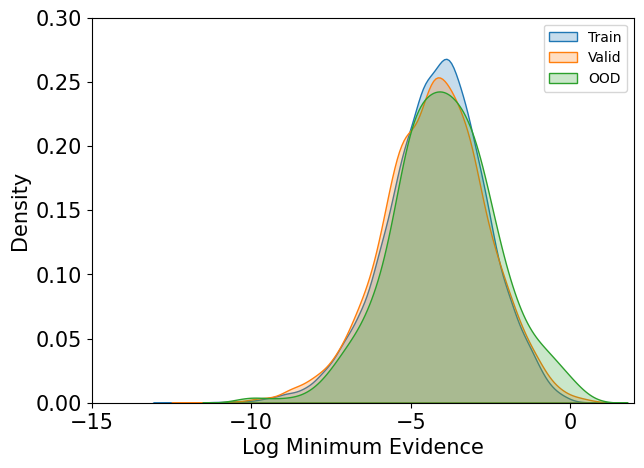

In [20]:
min_output_train = torch.min((train_output_recont),dim=1)[0]
min_output_valid = torch.min((valid_output_recont),dim=1)[0]
min_output_ood = torch.min((ood_output_recont),dim=1)[0]

plt.figure(figsize=(7,5))
plt.rcdefaults()
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(min_output_train.cpu().numpy(), label='Train', fill=True)
sns.kdeplot(min_output_valid.cpu().numpy(), label='Valid', fill=True)
sns.kdeplot(min_output_ood.cpu().numpy(), label='OOD', fill=True)
plt.xlabel('Log Minimum Evidence', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend()
plt.xlim(-15,2)
plt.ylim(0,0.3)
plt.xticks(np.arange(-15,3,5))
plt.yticks(np.arange(0,0.31,0.05))
plt.savefig('LogMinEvidence_recon.png')

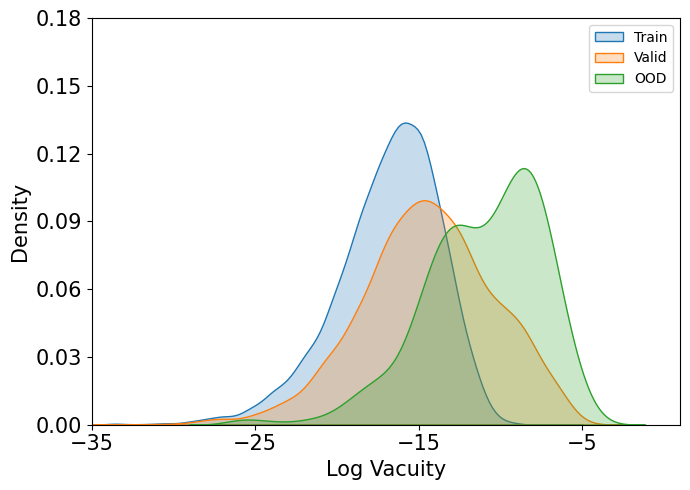

In [22]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_recon), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_recon), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_recon), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(-35,1)
plt.ylim(0,0.18)
plt.xticks(np.arange(-35,1,10))
plt.yticks(np.arange(0,0.19,0.03))
plt.legend()
plt.tight_layout()
plt.savefig('density_recon.png')

Conclusion : didn't really help model the shared evidence

## 4. ROLENet
(at last we name it rolenet)

In [23]:
subevidencenet = SubEvidenceNet('ResNet18', num_class)
subevidencenet.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/rolenet_acc.pth').state_dict())
subevidencenet = subevidencenet.cuda()

train_loss_sub, train_acc_sub, train_output_sub, train_features_sub, train_targets_sub = evaluate(subevidencenet, train_dl, 1, ood=False)
valid_loss_sub, valid_acc_sub, valid_output_sub, valid_features_sub, valid_targets_sub = evaluate(subevidencenet, valid_dl, 1, ood=False)
ood_loss_sub, ood_acc_sub, ood_output_sub, ood_features_sub, ood_targets_sub = evaluate(subevidencenet, ood_dl, 1, ood=True)

train_output_subt = train_output_sub
valid_output_subt = valid_output_sub
ood_output_subt = ood_output_sub

train_prob_subt = get_prob(train_output_subt)
valid_prob_subt = get_prob(valid_output_subt)
ood_prob_subt = get_prob(ood_output_subt)

train_vacuity_subt = get_vacuity(train_output_subt)
valid_vacuity_subt = get_vacuity(valid_output_subt)
ood_vacuity_subt = get_vacuity(ood_output_subt)

print('acc:',valid_acc_sub.item(),'\n')
print('SubEvidenceNet-T-Vacuity')
ood_metric_vacuity_subt = metric_ood(ood_vacuity_subt, valid_vacuity_subt, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_subt, valid_vacuity_subt),'\n')


train_output_sub = train_output_sub - torch.min(train_output_sub, dim=1, keepdim=True)[0]
valid_output_sub = valid_output_sub - torch.min(valid_output_sub, dim=1, keepdim=True)[0]
ood_output_sub = ood_output_sub - torch.min(ood_output_sub, dim=1, keepdim=True)[0]

train_prob_sub = get_prob(train_output_sub)
valid_prob_sub = get_prob(valid_output_sub)
ood_prob_sub = get_prob(ood_output_sub)

train_vacuity_sub = get_vacuity(train_output_sub)
valid_vacuity_sub = get_vacuity(valid_output_sub)
ood_vacuity_sub = get_vacuity(ood_output_sub)

print('acc:', valid_acc_sub.item(),'\n')
print('SubEvidenceNet-Vacuity')
ood_metric_vacuity_sub = metric_ood(ood_vacuity_sub, valid_vacuity_sub, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_vacuity_sub, valid_vacuity_sub),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:06<00:00,  3.03s/it]

acc: 0.8729016786570742 

SubEvidenceNet-T-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    29.780 76.400 70.535 24.365 96.375
fpr95: 69.54436450839329 

acc: 0.8729016786570742 

SubEvidenceNet-Vacuity
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    24.613 75.135 69.122 23.541 96.098
fpr95: 74.9727490734685 



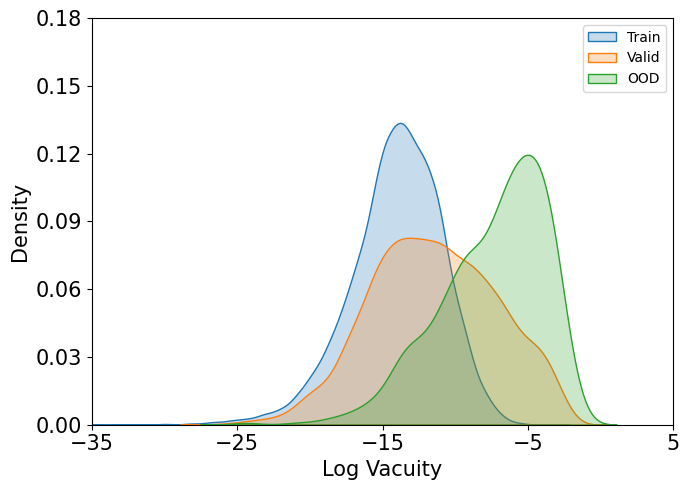

In [27]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_subt), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_subt), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_subt), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(-35,5)
plt.ylim(0,0.18)
plt.xticks(np.arange(-35,6,10))
plt.yticks(np.arange(0,0.19,0.03))
plt.legend()
plt.tight_layout()
plt.savefig('density_subt.png')

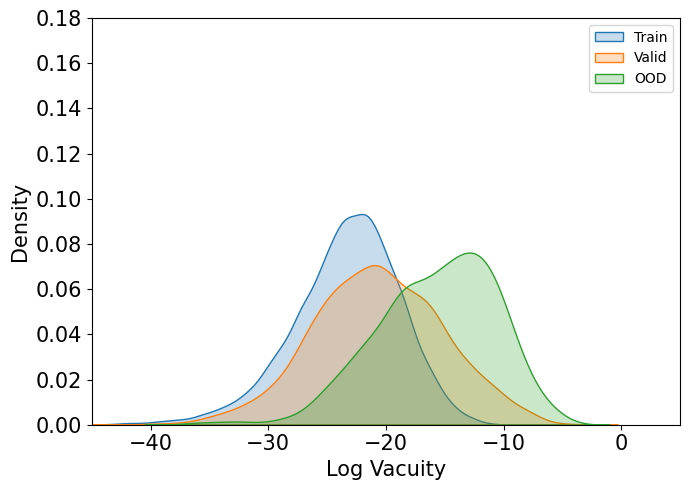

In [29]:
plt.figure(figsize=(7,5))
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
sns.kdeplot(np.log(train_vacuity_sub), label='Train', fill=True)
sns.kdeplot(np.log(valid_vacuity_sub), label='Valid', fill=True)
sns.kdeplot(np.log(ood_vacuity_sub), label='OOD', fill=True)
plt.xlabel('Log Vacuity', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(-45,5)
plt.ylim(0,0.18)
plt.legend()
plt.tight_layout()
plt.savefig('density_sub.png')

## Add1. PriorNet

In [32]:
from Methods.PriorNet import PriorNet

prior = PriorNet('ResNet18', num_class)
prior.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/priornet_acc.pth').state_dict())
prior = prior.cuda()

train_loss_prior, train_acc_prior, train_output_prior, train_features_prior, train_targets_prior = evaluate(prior, train_dl, 1, ood=False)
valid_loss_prior, valid_acc_prior, valid_output_prior, valid_features_prior, valid_targets_prior = evaluate(prior, valid_dl, 1, ood=False)
ood_loss_prior, ood_acc_prior, ood_output_prior, ood_features_prior, ood_targets_prior = evaluate(prior, ood_dl, 1, ood=True)

train_prob_prior = get_prob(train_output_prior)
valid_prob_prior = get_prob(valid_output_prior)
ood_prob_prior = get_prob(ood_output_prior)

train_entropy_prior = get_entropy(train_prob_prior)
valid_entropy_prior = get_entropy(valid_prob_prior)
ood_entropy_prior = get_entropy(ood_prob_prior)

print('acc:', valid_acc_prior.item(),'\n')
print('PriorNet-Entropy')
ood_metric_entropy_prior = metric_ood(ood_entropy_prior, valid_entropy_prior, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_entropy_prior, valid_entropy_prior),'\n')

Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]

acc: 0.882494004796163 

PriorNet-Entropy
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas    11.489 68.477 66.791 19.394 94.306
fpr95: 88.31480270329192 



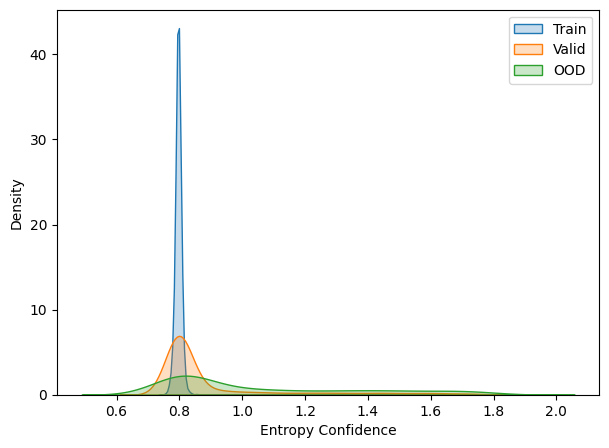

In [34]:
plt.figure(figsize=(7,5))
sns.kdeplot((train_entropy_prior), label='Train', fill=True)
sns.kdeplot((valid_entropy_prior), label='Valid', fill=True)
sns.kdeplot((ood_entropy_prior), label='OOD', fill=True)
plt.xlabel('Entropy Confidence')
plt.ylabel('Density')
plt.legend()
plt.savefig('density_prior.png')

## Add2. RePriorNet

In [35]:
from Methods.PriorNet_Re import PriorNet_Re
repriornet = PriorNet_Re('ResNet18', num_class)
repriornet.load_state_dict(torch.load('/mnt/Codes/kella/ROLE/Results/runs_openset_isic/repriornet_acc.pth').state_dict())
repriornet = repriornet.cuda()

train_loss_reprior, train_acc_reprior, train_output_reprior, train_features_reprior, train_targets_reprior = evaluate(repriornet, train_dl, 1, ood=False)
valid_loss_reprior, valid_acc_reprior, valid_output_reprior, valid_features_reprior, valid_targets_reprior = evaluate(repriornet, valid_dl, 1, ood=False)
ood_loss_reprior, ood_acc_reprior, ood_output_reprior, ood_features_reprior, ood_targets_reprior = evaluate(repriornet, ood_dl, 1, ood=True)

train_prob_reprior = get_prob(train_output_reprior)
valid_prob_reprior = get_prob(valid_output_reprior)
ood_prob_reprior = get_prob(ood_output_reprior)

train_entropy_reprior = get_entropy(train_prob_reprior)
valid_entropy_reprior = get_entropy(valid_prob_reprior)
ood_entropy_reprior = get_entropy(ood_prob_reprior)

print('acc:', valid_acc_reprior.item(),'\n')
print('PriorNet-Re-Entropy')
ood_metric_entropy_reprior = metric_ood(ood_entropy_reprior, valid_entropy_reprior, ['Bas'], verbose=True)
print('fpr95:',get_fpr95(ood_entropy_reprior, valid_entropy_reprior),'\n')


Evaluate OOD: 1: 100%|██████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]

acc: 0.8766078046653586 

PriorNet-Re-Entropy
       TNR    AUROC  DTACC  AUIN   AUOUT 
Bas     9.810 69.293 65.804 19.870 94.445
fpr95: 87.35557008938304 



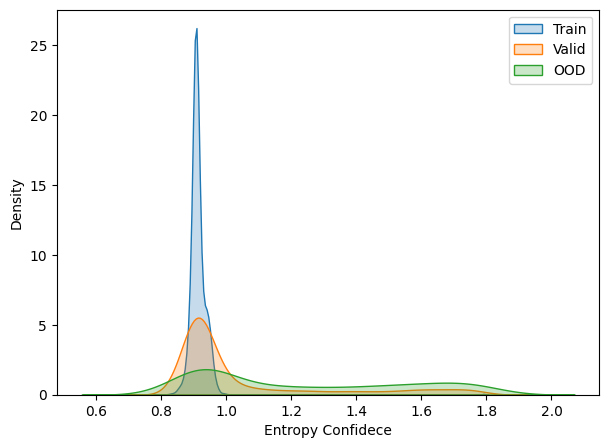

In [37]:
plt.figure(figsize=(7,5))
sns.kdeplot((train_entropy_reprior), label='Train', fill=True)
sns.kdeplot((valid_entropy_reprior), label='Valid', fill=True)
sns.kdeplot((ood_entropy_reprior), label='OOD', fill=True)
plt.xlabel('Entropy Confidece')
plt.ylabel('Density')
plt.legend()
plt.savefig('density_reprior.png')